In [1]:
from shapely.geometry import Polygon, MultiPolygon
import itertools
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
import numpy as np
import shapely.wkt as wkt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [2]:
import xarray as xr
import rioxarray as riox
from xrspatial import convolution, focal
from skimage.transform import resize
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
display(client)

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-5b37ae04', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-98lb4vr_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-ccn9s7tg', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-ddmoilyv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-dmsdyj6e', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-mwdstd6l', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38303,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:40067,Total threads: 2
Dashboard: http://127.0.0.1:37245/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:46621,


In [3]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)

def calc_tpi(dtm, inner_r, outer_r, interpolate=True, values=True, bounds=(-2.0, 3.0), fillna=None):
    cellsize_x, cellsize_y = convolution.calc_cellsize(dtm)
    kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_r, inner_r)
    tpi = dtm - focal.apply(dtm, kernel)
    tpi = tpi.rio.write_nodata(-9999.)
    tpi = tpi.where((tpi > bounds[0]) & (tpi < bounds[1]))
    if interpolate:
        if tpi.isnull().any().values:
            tpi = tpi.rio.interpolate_na(method='nearest')
    if fillna is not None:
        tpi = tpi.fillna(fillna)
    if values:
        return tpi.values
    else:
        return tpi

def calc_ndvi(ms, interpolate=True, values=True, fillna=None):
    ndvi = (ms.sel(band=4).astype('float32') - ms.sel(band=3).astype('float32'))\
            / (ms.sel(band=4).astype('float32') + ms.sel(band=3).astype('float32'))
    ndvi = ndvi.rio.write_nodata(-9999.)
    ndvi = ndvi.where(ndvi != -9999.)
    if interpolate:
        if ndvi.isnull().any().values:
            ndvi = ndvi.rio.interpolate_na(method='nearest')
    if fillna is not None:
        ndvi = ndvi.fillna(fillna)
    if values:
        return ndvi.values
    else:
        return ndvi
    
def hillshade(array, azimuth=225, angle_altitude=45):
    """https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py"""
    azimuth = 360.0 - azimuth 
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    return 255*(shaded + 1)/2

In [4]:
gdf_pdog_burrows = gpd.read_file('ground_data/cper_pdog_points_2021Sept_burrows.shp')
gdf_pdog_other = gpd.read_file('ground_data/cper_pdog_points_2021Sept_other.shp')
gdf_pdog_old = gpd.read_file('ground_data/cper_pdog_points_old_2021Sept.shp')
gdf_pdog_non = gpd.read_file('ground_data/cper_pdog_points_non_2021Sept.shp')
gdf_pdog_points = pd.concat([gdf_pdog_burrows, gdf_pdog_other, gdf_pdog_old, gdf_pdog_non], ignore_index=True)

In [5]:
gdf_pdog_points

,Comment,Pasture,height,size,activity,vegetation,is_burrow,geometry
0,h0s1a2v2,22E,0.0,1.0,2.0,2.0,1,POINT Z (520461.553 4518295.570 1620.810)
1,h2s1a3v1,22E,2.0,1.0,3.0,1.0,1,POINT Z (520452.430 4518297.281 1620.839)
2,h0s0a1v2,22E,0.0,0.0,1.0,2.0,1,POINT Z (520450.601 4518299.095 1620.966)
3,h1s1a2v2,22E,1.0,1.0,2.0,2.0,1,POINT Z (520443.890 4518293.633 1619.823)
4,h1s1a2v3,22E,1.0,1.0,2.0,3.0,1,POINT Z (520435.802 4518297.874 1620.709)
...,...,...,...,...,...,...,...,...
386,old,5W,NaN,NaN,NaN,NaN,0,POINT Z (525750.551 4523360.938 1626.842)
387,den,5W,NaN,NaN,NaN,NaN,0,POINT Z (525742.869 4523377.456 1626.842)
388,old,5W,NaN,NaN,NaN,NaN,0,POINT Z (525714.072 4523386.815 1626.836)
389,h0s2a0v2,5W,0.0,2.0,0.0,2.0,1,POINT Z (525700.902 4523391.770 1626.956)


In [6]:
gdf_plots = gpd.read_file('ground_data/cper_pdog_polys_2021Sept.shp')
gdf_plots_non = gpd.read_file('ground_data/cper_pdog_polys_non_2021Sept.shp')
gdf_plots_old = gpd.read_file('ground_data/cper_pdog_polys_old_2021Sept.shp')
gdf_plots_all = pd.concat([gdf_plots, gdf_plots_non, gdf_plots_old], ignore_index=True)

In [7]:
gdf_plots_all

,Comment,Pasture,geometry
0,22e,22E,"POLYGON Z ((520463.787 4518342.779 1621.710, 5..."
1,22w,22W,"POLYGON Z ((519990.563 4518751.042 1628.805, 5..."
2,29-30a,29-30,"POLYGON Z ((525286.488 4516667.053 1609.465, 5..."
3,5w,5W,"POLYGON Z ((525725.613 4522893.257 1625.306, 5..."
4,cn1,CN,"POLYGON Z ((519876.267 4517043.700 1613.745, 5..."
5,cn2,CN,"POLYGON Z ((519840.200 4516657.034 1610.727, 5..."
6,cn3,CN,"POLYGON Z ((520019.957 4517521.168 1616.768, 5..."
7,5W_non,5W,"POLYGON ((525630.872 4523259.933, 525630.872 4..."
8,old29-30,29-30,"POLYGON Z ((526292.523 4516639.320 1590.652, 5..."
9,old29-30b,29-30,"POLYGON Z ((525012.857 4516340.402 1622.147, 5..."


In [8]:
df_polys = pd.read_csv('train_polys/train_polys_all.csv')
df_polys['geometry'] = df_polys.geometry.apply(lambda x: Polygon(wkt.loads(x)))
gdf_polys = gpd.GeoDataFrame(df_polys, geometry='geometry')
gdf_polys = gdf_polys.set_crs(32613)

In [9]:
df_polys

,Unnamed: 0,orig_index,Comment,Tile,Trainer,geometry,group,subID
0,0,0,NaN,CN_50,Sean,"POLYGON ((519835.548 4516699.658, 519836.043 4...",random,0
1,1,1,NaN,CN_50,Sean,"POLYGON ((519837.998 4516708.403, 519838.603 4...",random,1
2,2,2,NaN,CN_50,Sean,"POLYGON ((519828.005 4516706.137, 519828.336 4...",random,2
3,3,3,NaN,CN_50,Sean,"POLYGON ((519849.530 4516703.545, 519850.209 4...",random,3
4,4,4,NaN,CN_50,Sean,"POLYGON ((519849.728 4516697.939, 519850.294 4...",random,4
...,...,...,...,...,...,...,...,...
374,448,64,NaN,22W_14,David,"POLYGON ((519588.080 4518187.215, 519589.099 4...",random,3
375,449,65,NaN,22W_14,David,"POLYGON ((519587.764 4518179.192, 519589.064 4...",random,4
376,450,66,NaN,22W_0,David,"POLYGON ((519853.938 4519328.380, 519854.331 4...",random,0
377,451,67,NaN,22W_0,David,"POLYGON ((519860.298 4519320.625, 519860.859 4...",random,1


In [10]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'# 'cpu'# 
model_fnl = 'deeplabplus'
res_fnl = 5
inputs_fnl = ['rgb', 'tpi', 'ndvi'] 
preprocess = True

In [11]:
# load best saved checkpoint
if res_fnl == 2:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '.pth')
else:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '_' + str(res_fnl) + 'cm.pth')
    
best_model.eval()

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [12]:
image_stats

{'rgb': {'min': 0.0, 'max': 255.0},
 'tpi': {'min': -0.1, 'max': 0.4},
 'ndvi': {'min': 0.0, 'max': 1.0}}

In [13]:
gdf_plots[gdf_plots['Pasture'] == '29-30']

,Comment,Pasture,geometry
2,29-30a,29-30,"POLYGON Z ((525286.488 4516667.053 1609.465, 5..."


In [14]:
res_chunk_dict = {
    2.0: 256,
    5.0: 160,
    10.0: 128,
    15.0: 96,
    30.0: 64
}

In [15]:
from rioxarray.merge import merge_arrays

In [16]:
past = '5W'
plot_i = 0
#rgb_f = '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_ortho.tif'
#dsm_f = '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_dsm.tif'
#ms_f = '/mnt/d/202109/outputs/202109_29_30_MS/CPER_202109_29_30_South_MS_ortho.tif'

rgb_f = '/mnt/d/202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_ortho.tif'
dsm_f = '/mnt/d/202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_dsm.tif'
ms_f = '/mnt/d/202109/outputs/202109_5W_MS/CPER_202109_5W_MS_ortho.tif'

In [25]:
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = gdf_plots[gdf_plots['Pasture'] == past].geometry.bounds[['minx', 'maxx']].iloc[plot_i].values
box_coords_y = gdf_plots[gdf_plots['Pasture'] == past].geometry.bounds[['miny', 'maxy']].iloc[plot_i].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
poly_geom = Polygon([ll, ul, ur, lr])
# create a polygon from the coordinate pairs
#poly_geom = gdf_plots[gdf_plots['Pasture'] == '22E'].geometry[0]
# create the full path to the RGB image of the training tile
with riox.open_rasterio(rgb_f, masked=True, cache=False) as rgb_src:   
    rgb_xr_mem = rgb_src.sel(band=slice(0, 3),
                             x=slice(ll[0], lr[0]),
                             y=slice(ul[1], ll[1]), 
                             drop=True).load()
    rgb_xr_mem = rgb_xr_mem.where(rgb_xr_mem != 255)
    rgb_xr_mem = rgb_xr_mem.rio.write_nodata(-9999.)

    rgb_xr = merge_arrays([rgb_xr_mem],
                          bounds=(ll[0], ll[1], lr[0], ur[1]), 
                          res=res_fnl*0.01, 
                          crs=rio.CRS.from_epsg(32613),
                          method='first',
                          nodata=-9999.)
    rgb_xr = rgb_xr.where(rgb_xr != -9999.)
    
    gdf_polys_sub = gdf_polys[gdf_polys.geometry.within(poly_geom)]
    if len(gdf_polys_sub) > 0:
        label_mask = rasterize(gdf_polys_sub.geometry, 
                          out_shape=rgb_xr.shape[1:], transform=rgb_xr.rio.transform(),
                          default_value=1)
    else:
         label_mask = np.zeros_like(rgb_xr.data[0, :, :])   
    label_mask = label_mask.astype('int')    

In [26]:
with riox.open_rasterio(dsm_f,
                        masked=True, cache=False) as dsm_src:
    dsm_xr_mem = dsm_src.sel(x=slice(ll[0], lr[0]),
                         y=slice(ul[1], ll[1]), 
                         drop=True).squeeze().load()
dsm_xr_mem = dsm_xr_mem.where(dsm_xr_mem > 0)
dsm_xr_mem = dsm_xr_mem.rio.write_nodata(-9999.)

dsm_xr = merge_arrays([dsm_xr_mem],
                      bounds=(ll[0], ll[1], lr[0], ur[1]), 
                      res=res_fnl*0.01, 
                      crs=rio.CRS.from_epsg(32613),
                      method='first',
                      nodata=-9999.)
dsm_xr = dsm_xr.where(dsm_xr != -9999.)

# create the TPI image
outer_radius = "0.75m"
inner_radius = "0.25m"
tpi_xr = calc_tpi(dsm_xr.chunk({'x': 300,
                                'y': 300}), 
                  inner_r=inner_radius, 
                  outer_r=outer_radius, 
                  interpolate=False,
                  values=False)

with riox.open_rasterio(ms_f,
                        masked=True, cache=False) as ms_src:
    ms_xr_mem = ms_src.sel(band=[4, 3],
                           x=slice(ll[0], lr[0]),
                           y=slice(ul[1], ll[1]), 
                           drop=True).load()

ms_xr_mem = ms_xr_mem.where(ms_xr_mem != 65535)
ms_xr_mem = ms_xr_mem.rio.write_nodata(-9999.)

ms_xr = merge_arrays([ms_xr_mem],
                      bounds=(ll[0], ll[1], lr[0], ur[1]), 
                      res=res_fnl*0.01, 
                      crs=rio.CRS.from_epsg(32613),
                      method='first',
                      nodata=-9999.)

ms_xr = ms_xr.where(ms_xr != -9999.)

ndvi_xr = calc_ndvi(ms_xr, interpolate=False, values=False)

# create a hillshade image for vizualization
if True:
    # create a hillshade image
    shade_xr = xr.apply_ufunc(hillshade, dsm_xr, vectorize=False, dask='parallelized', output_dtypes='int')
    
tile_size = res_chunk_dict[res_fnl]
buff_size = 64 - 16*int(np.ceil(256/tile_size)) + 16

n_row_chunks = int(np.ceil(rgb_xr.shape[1]/tile_size))
n_col_chunks = int(np.ceil(rgb_xr.shape[2]/tile_size))

pr_mask = np.empty_like(rgb_xr.values[0, :, :])
image_dict = {}
image_dict['tpi'] = np.expand_dims(tpi_xr.values, 0)
#image_dict['tpi'] = resize(image_dict['tpi'].transpose((1, 2, 0)), (rgb_xr.shape[1], rgb_xr.shape[2], 1)).transpose((2, 0, 1))
image_dict['shade'] = np.expand_dims(shade_xr.values, 0)
#image_dict['shade'] = resize(image_dict['shade'].transpose((1, 2, 0)), (rgb_xr.shape[1], rgb_xr.shape[2], 1)).transpose((2, 0, 1))
image_dict['dsm'] = np.expand_dims(dsm_xr.values, 0)
image_dict['ndvi'] = np.expand_dims(ndvi_xr.values, 0)
for r in range(n_row_chunks):
    if (r + 1) * tile_size > rgb_xr.shape[1]:
        r_min = rgb_xr.shape[1] - tile_size
        r_max = rgb_xr.shape[1]
        r_max_comp = rgb_xr.shape[1]
    elif (r + 1) * tile_size + buff_size > rgb_xr.shape[1]:
        r_min = r * tile_size
        r_max = (r + 1) * tile_size
        r_max_comp = r_max
    else:
        r_min = r * tile_size
        r_max = (r + 1) * tile_size
        r_max_comp = r_max + buff_size
    for c in range(n_col_chunks):
        image_sub_dict = {}
        if (c + 1) * tile_size > rgb_xr.shape[2]:
            c_min = rgb_xr.shape[2] - tile_size
            c_max = rgb_xr.shape[2]
            c_max_comp = rgb_xr.shape[2]
        elif (c + 1) * tile_size + buff_size > rgb_xr.shape[2]:
            c_min = c * tile_size
            c_max = (c + 1) * tile_size
            c_max_comp = c_max
        else:
            c_min = c * tile_size
            c_max = (c + 1) * tile_size
            c_max_comp = c_max + buff_size
        #print(r_min, r_max, c_min, c_max)
        for k in image_dict:
            image_sub_dict[k] = image_dict[k][:,
                                              max(0, r_min-buff_size):r_max_comp, 
                                              max(0, c_min-buff_size):c_max_comp].astype('float32')
        if 'rgb' in inputs_fnl:
            image_sub_dict['rgb'] = rgb_xr.values[:, 
                                            max(0, r_min-buff_size):r_max_comp, 
                                            max(0, c_min-buff_size):c_max_comp].astype('float32')
        if preprocess:
            for i in image_sub_dict:
                image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
        image_list = [image_sub_dict[i] for i in inputs_fnl]
        image_out = np.concatenate(image_list, axis=0)
        x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
        if type(best_model) == nn.DataParallel:
            pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
            buff_r_min = buff_size * int(r_min-buff_size > 0)
            buff_r_max = buff_size * int(r_max+buff_size < rgb_xr.shape[1])
            buff_c_min = buff_size * int(c_min-buff_size > 0)
            buff_c_max = buff_size * int(c_max+buff_size < rgb_xr.shape[2])
            if pred_tmp.shape[1] > tile_size:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
            else:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
        else:
            pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
            buff_r_min = buff_size * int(r_min-buff_size > 0)
            buff_r_max = buff_size * int(r_max+buff_size < rgb_xr.shape[1])
            buff_c_min = buff_size * int(c_min-buff_size > 0)
            buff_c_max = buff_size * int(c_max+buff_size < rgb_xr.shape[2])
            if pred_tmp.shape[1] > tile_size:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
            else:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp

# create mask of ground-truth polygon
gt_plot_mask = rasterize(gdf_plots_all.geometry, 
                         out_shape=rgb_xr.shape[1:], transform=rgb_xr.rio.transform(),
                         default_value=1)
gt_plot_mask = gt_plot_mask.astype('int')   

# get predictions for ground-truth points
gdf_pdog_points_sub = gdf_pdog_points[gdf_pdog_points.geometry.within(poly_geom)]
if len(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] == 1]) > 0:
    burrows_mask = rasterize(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] == 1].geometry.buffer(0.5), 
                                  out_shape=rgb_xr.shape[1:], transform=rgb_xr.rio.transform(),
                                  default_value=1)    
    burrows_mask = burrows_mask.astype('int')   
else:
    burrows_mask = np.zeros_like(rgb_xr.data[0, :, :]) 
    
if len(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] != 1]) > 0:
    non_mask = rasterize(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] != 1].geometry.buffer(0.5), 
                                  out_shape=rgb_xr.shape[1:], transform=rgb_xr.rio.transform(),
                                  default_value=1)    
    non_mask = non_mask.astype('int')   
else:
    non_mask = np.zeros_like(rgb_xr.data[0, :, :]) 

if len(gdf_pdog_points_sub[gdf_pdog_points_sub['Comment'] == 'ant']) > 0:
    ant_mask = rasterize(gdf_pdog_points_sub[gdf_pdog_points_sub['Comment'] == 'ant'].geometry.buffer(0.5), 
                                  out_shape=rgb_xr.shape[1:], transform=rgb_xr.rio.transform(),
                                  default_value=1)    
    ant_mask = ant_mask.astype('int')   
else:
    ant_mask = np.zeros_like(rgb_xr.data[0, :, :]) 

    
# mask all arrays to ground-truth polygon
pr_mask = pr_mask * gt_plot_mask
label_mask = label_mask * gt_plot_mask
burrows_mask = burrows_mask * gt_plot_mask
non_mask = non_mask * gt_plot_mask
ant_mask = ant_mask * gt_plot_mask

In [27]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
cmap_burrow = ListedColormap(['black', 'tab:cyan'])
cmap_pr = ListedColormap(['black', 'tab:olive'])
cmap_ant = ListedColormap(['tab:orange', 'tab:orange'])

In [28]:
non_mask = np.ma.masked_where(non_mask == 0, non_mask)
ant_mask = np.ma.masked_where(ant_mask == 0, ant_mask)

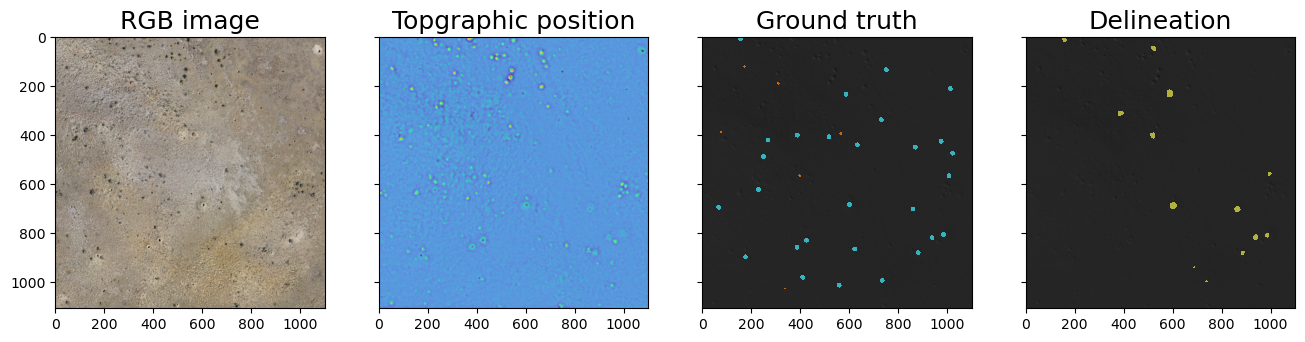

In [29]:
fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(rgb_xr.values.transpose((1, 2, 0)).astype('int'))
axs[1].imshow(image_dict['shade'].squeeze(), cmap='Greys_r')
axs[1].imshow(image_dict['tpi'].squeeze(), cmap='turbo', clim=(-0.1, 0.4), alpha=0.7)
axs[2].imshow(image_dict['shade'].squeeze(), cmap='Greys_r')
axs[2].imshow(burrows_mask, cmap=cmap_burrow, alpha=0.75)
axs[2].imshow(ant_mask, cmap=cmap_ant, alpha=0.75)
axs[3].imshow(image_dict['shade'].squeeze(), cmap='Greys_r')
axs[3].imshow(label_mask, cmap_pr, alpha=0.75)

ax_titles = ['RGB image', 'Topgraphic position', 'Ground truth', 'Delineation']
# Add the patch to the Axes
for idx, ax in enumerate(axs):
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    ax.set_title(ax_titles[idx], fontsize=18)

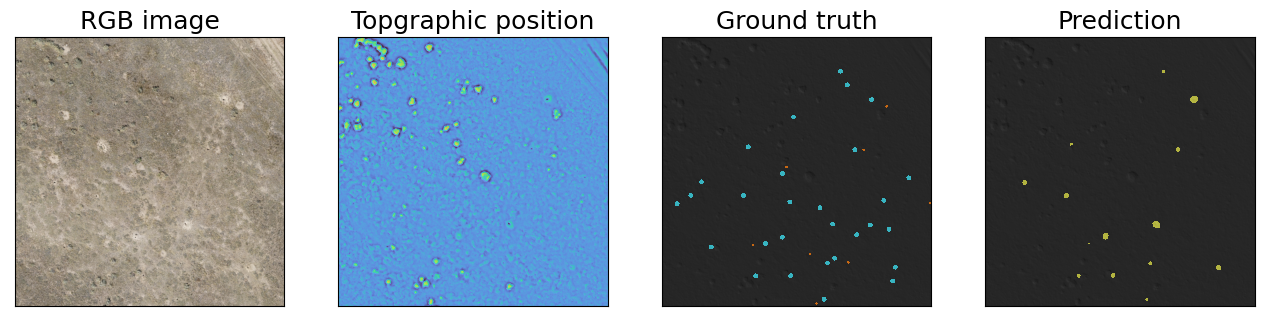

In [41]:
plt_r_sub0 = 0
plt_r_sub1 = 1100
plt_c_sub0 = 0
plt_c_sub1 = 1100

r_sub0 = 2000
r_sub1 = 2350
c_sub0 = 1200
c_sub1 = 1750

fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(rgb_xr.data.transpose((1, 2, 0))[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1, :].astype('int'))
axs[1].imshow(image_dict['shade'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='Greys_r')
axs[1].imshow(image_dict['tpi'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='turbo', clim=(-0.1, 0.4), alpha=0.7)
axs[2].imshow(image_dict['shade'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='Greys_r')
axs[2].imshow(burrows_mask[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap=cmap_burrow, alpha=0.75)
axs[2].imshow(ant_mask[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap=cmap_ant, alpha=0.75)
axs[3].imshow(image_dict['shade'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='Greys_r')
axs[3].imshow(pr_mask[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap_pr, alpha=0.75)

ax_titles = ['RGB image', 'Topgraphic position', 'Ground truth', 'Prediction']
# Add the patch to the Axes
for idx, ax in enumerate(axs):
    # Create a Rectangle patch
    rect = patches.Rectangle((c_sub0, r_sub0), c_sub1-c_sub0, r_sub1 - r_sub0, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(ax_titles[idx], fontsize=18)
#plt.savefig('./results_figs/full_example.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

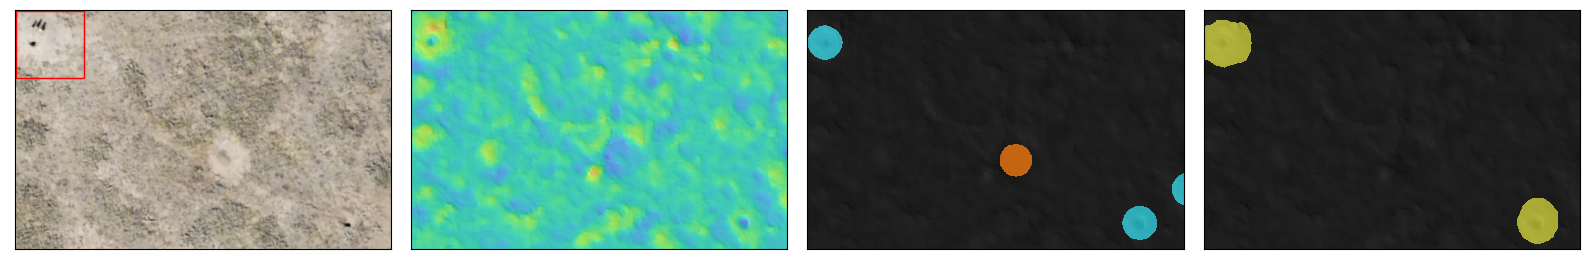

In [62]:
#r_sub0 = 2000
#r_sub1 = 2400
#c_sub0 = 1200
#c_sub1 = 1800
pdog_r_sub0 = 1
pdog_r_sub1 = 100
pdog_c_sub0 = 1
pdog_c_sub1 = 100

fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(rgb_out.transpose((1, 2, 0))[r_sub0:r_sub1, c_sub0:c_sub1, :].astype('int'))
rect = patches.Rectangle((pdog_c_sub0, pdog_r_sub0), pdog_c_sub1-pdog_c_sub0, pdog_r_sub1 - pdog_r_sub0, linewidth=1, edgecolor='r', facecolor='none')
axs[0].add_patch(rect)
axs[1].imshow(image_dict['shade'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r')
axs[1].imshow(image_dict['tpi'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='turbo', clim=(-0.1, 0.2), alpha=0.7)
#axs[1].imshow(image_dict['dsm'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='turbo', alpha=0.7)
axs[2].imshow(image_dict['shade'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r')
axs[2].imshow(image_dict['tpi'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r', clim=(-0.1, 0.3), alpha=0.5)
axs[2].imshow(burrows_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap_burrow, alpha=0.75)
axs[2].imshow(ant_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_ant, alpha=0.75)
axs[3].imshow(image_dict['shade'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r')
axs[3].imshow(image_dict['tpi'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r', clim=(-0.1, 0.3), alpha=0.5)
axs[3].imshow(pr_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap_pr, alpha=0.75)
#axs[3].imshow(ant_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_ant, clim=(0, 2), alpha=0.75)

for idx, ax in enumerate(axs):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
plt.tight_layout()
#plt.savefig('./results_figs/zoom_example.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

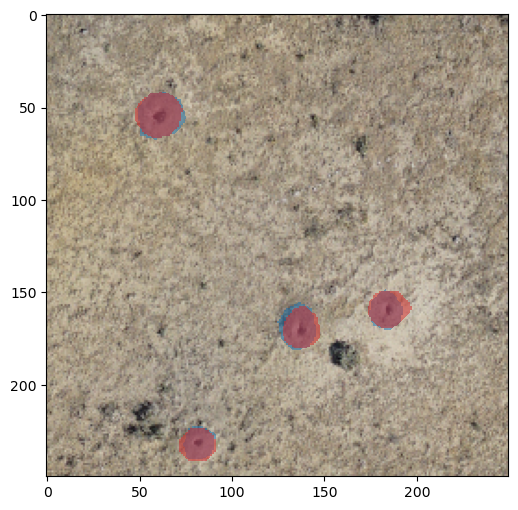

In [34]:
r_sub0 = 650
r_sub1 = 900
c_sub0 = 800
c_sub1 = 1050

cmap_label = ListedColormap(['#FFFFFF00', 'tab:blue'])
cmap_pr2 = ListedColormap(['#FFFFFF00', 'tab:red'])

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ax.imshow(rgb_xr.data.transpose((1, 2, 0))[r_sub0:r_sub1, c_sub0:c_sub1, :].astype('int'))
ax.imshow(label_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_label, alpha=0.5)
ax.imshow(pr_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap_pr2, alpha=0.5)
#axs[3].imshow(ant_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_ant, clim=(0, 2), alpha=0.75)

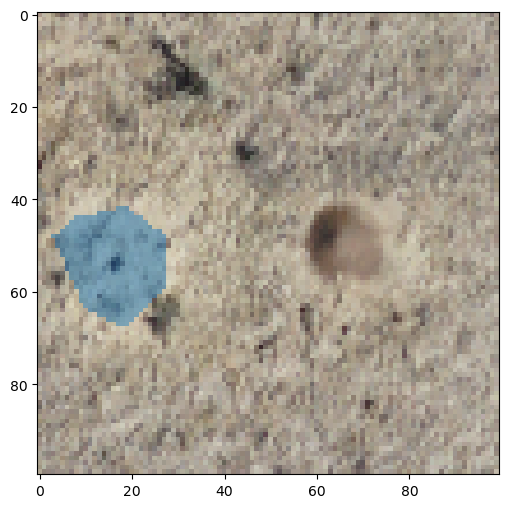

In [44]:
r_sub0 = 350
r_sub1 = 450
c_sub0 = 500
c_sub1 = 600

cmap_label = ListedColormap(['#FFFFFF00', 'tab:blue'])
cmap_pr2 = ListedColormap(['#FFFFFF00', 'tab:red'])

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ax.imshow(rgb_xr.data.transpose((1, 2, 0))[r_sub0:r_sub1, c_sub0:c_sub1, :].astype('int'))
ax.imshow(label_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_label, alpha=0.5)
ax.imshow(pr_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap_pr2, alpha=0.5)
#axs[3].imshow(ant_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_ant, clim=(0, 2), alpha=0.75)

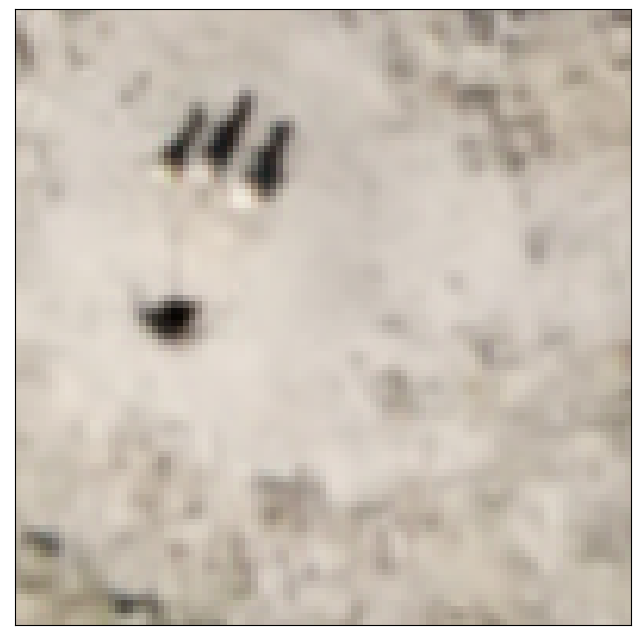

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_out.transpose((1, 2, 0))[r_sub0+pdog_r_sub0:r_sub0+pdog_r_sub1,
                                       c_sub0+pdog_c_sub0:c_sub0+pdog_c_sub1, :].astype('int'))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
    
#plt.savefig('./results_figs/pdog_superzoom_example.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

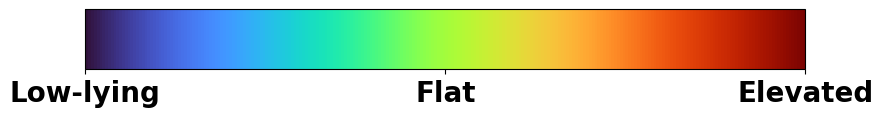

In [72]:
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.0))
img = plt.imshow(a, cmap="turbo")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
cax.set_xticks([0.0, 0.5, 1.0])
cax.set_xticklabels(['Low-lying', 'Flat', 'Elevated'], fontweight='bold', fontsize=20)
plt.savefig('./results_figs/tpi_colorbar.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [39]:
image_dict['tpi']

(1, 3709, 3427)

In [19]:
dsm_xr = riox.open_rasterio('/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif', masked=True)
dsm_xr = dsm_xr.rio.clip([poly_geom], drop=True, from_disk=True).squeeze()

# get cell size of the the DSM in prep foro TPI calculation
cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
# prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
outer_radius = str(cellsize_x * 10) + "m"
inner_radius = str(cellsize_x * 5) + "m"
kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)

# create the TPI image
tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)

In [23]:
tpi_xr.data

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  0.02111816,  0.01098633, ..., -0.0222168 ,
        -0.02722168,         nan],
       [        nan,  0.02124023,  0.01086426, ..., -0.01416016,
        -0.01928711,         nan],
       ...,
       [        nan, -0.0234375 , -0.02209473, ..., -0.00500488,
        -0.00097656,         nan],
       [        nan, -0.01977539, -0.0177002 , ..., -0.01062012,
        -0.02294922,         nan],
       [        nan, -0.01391602, -0.01074219, ..., -0.01574707,
        -0.02600098,         nan]])

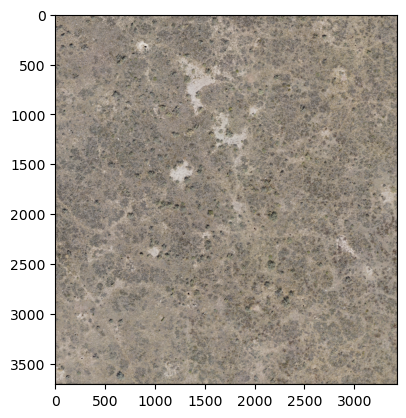

In [48]:
plt.imshow(rgb_out.transpose((1, 2, 0)))